Excerpted from _[Understanding pipelines, models, and schedulers](https://huggingface.co/docs/diffusers/using-diffusers/write_own_pipeline)_ in the [🤗 Diffusers documentation](https://huggingface.co/docs/diffusers).

In [14]:
%set_env PYTORCH_ENABLE_MPS_FALLBACK=1

from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, UniPCMultistepScheduler

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True)
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="text_encoder", use_safetensors=True
)
unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="unet", use_safetensors=True
)
scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [15]:
if torch.backends.cuda.is_built():
    torch_device = torch.device("cuda")
elif torch.backends.mps.is_available():
    torch_device = torch.device("mps")
else:
    torch_device = torch.device("cpu")

vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

The next step is to tokenize the text to generate embeddings. The text is used to condition the UNet model and steer the diffusion process towards something that resembles the input prompt.

The `guidance_scale` parameter determines how much weight should be given to the prompt when generating an image.

In [16]:
prompt = ["a photograph of an astronaut riding a horse"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.Generator(device=torch_device).manual_seed(0)  # Seed generator to create the initial latent noise
batch_size = len(prompt)


Tokenize the text and generate the embeddings from the prompt:

In [17]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

Generate the unconditional text embeddings which are the embeddings for the padding token. These need to have the same shape (`batch_size` and `seq_length`) as the conditional `text_embeddings`:

In [18]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

Concatenate the conditional and unconditional embeddings into a batch to avoid doing two forward passes:

In [19]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

Generate some initial random noise as a starting point for the diffusion process. This is the latent representation of the image, and it’ll be gradually denoised. At this point, the latent image is smaller than the final image size but that’s okay though because the model will transform it into the final 512x512 image dimensions later.

In [20]:
# The height and width are divided by 8 because the vae model has 3 down-sampling layers.
2 ** (len(vae.config.block_out_channels) - 1) == 8

True

In [21]:
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
    device=torch_device,
)

Start by scaling the input with the initial noise distribution, sigma, the noise scale value, which is required for improved schedulers like [UniPCMultistepScheduler](https://huggingface.co/docs/diffusers/v0.24.0/en/api/schedulers/unipc#diffusers.UniPCMultistepScheduler):

In [22]:
latents = latents * scheduler.init_noise_sigma

The last step is to create the denoising loop that’ll progressively transform the pure noise in latents to an image described by the prompt. The denoising loop needs to do three things:

1. Set the scheduler’s timesteps to use during denoising.
2. Iterate over the timesteps.
3. At each timestep, call the UNet model to predict the noise residual and pass it to the scheduler to compute the previous noisy sample.

In [23]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:10<00:00,  2.32it/s]


The final step is to use the `vae` to decode the latent representation into an image and get the decoded output with `sample`:

In [24]:
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

Convert the image to a PIL.Image to see the generated image!

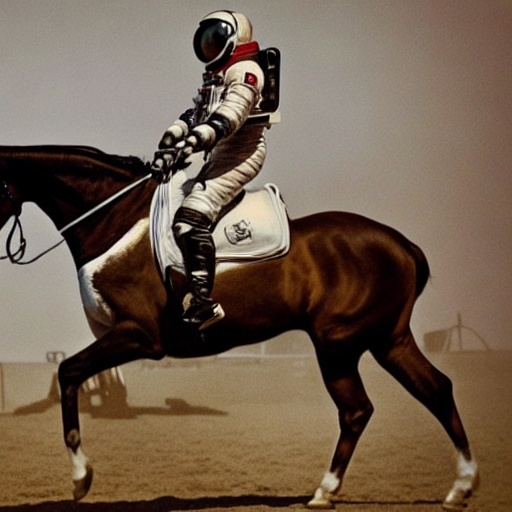

In [25]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
images = (image * 255).round().astype("uint8")
image = Image.fromarray(image)
image